In [50]:
import numpy as np
import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import BlockGf

Disclaimer:

Heavy calculations. Current parameters won't give converged solution but are simplified to give results on x cores in x hrs (estimates, depend on system of course).

# Running a charge self-consistent (CSC) calculation on PrNiO3 with VASP PLOs

In [1]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 150

## 1. Running the initial SCF DFT calculation (~ 1-2 core hours)

Get started:
- Go into folder `1_dft_scf`
- Insert POTCAR as concatenation of `PAW_PBE Pr_3`, `PAW_PBE Ni_pv` and `PAW_PBE O`
- Goal: get well-converged charge density (CHGCAR) and understand where correlated bands are (DOSCAR and potentially PROCAR and band structure)

Input files:
- INCAR: large number of steps for good convergence (relatively cheap calculation which will be starting point for future calculations)
- POSCAR: PrNiO3 close to experimental low-temperature structure (P21/n symmetry) -> insulating in experiment (true?)
- KPOINTS: approximately unidistant grid of 7 x 7 x 5

Run Vasp with `mpirun -n 8 vasp_std`.

Main output:
- CHGCAR: converged charge density to start the DMFT calculation from
- DOSCAR: to identify the energy range of the correlated subspace

In [2]:
dft_energy, dft_dos = np.loadtxt('1_dft_scf/refs/DOSCAR', skiprows=6, unpack=True, usecols=(0, 1))

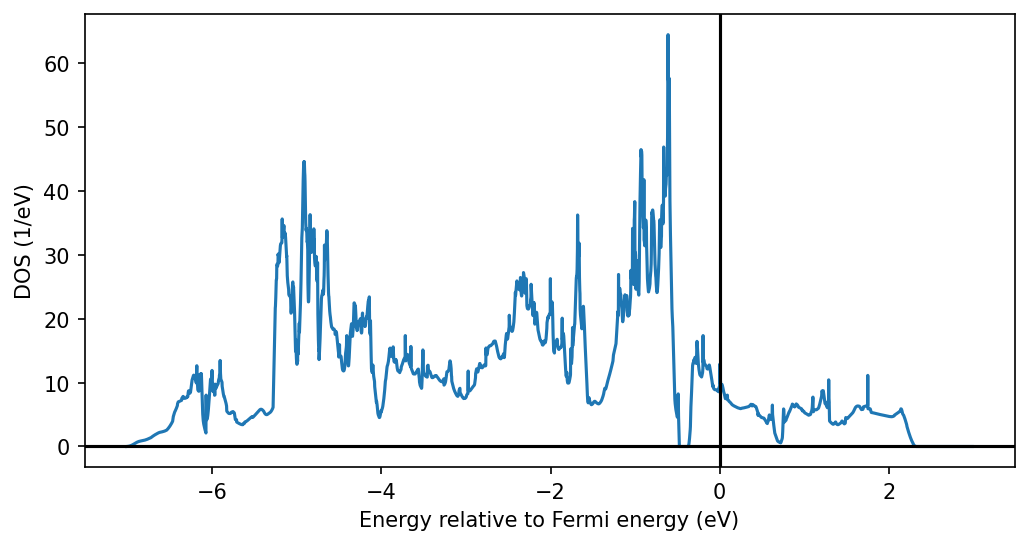

In [73]:
fermi_energy = 5.012206 # can be read from DOSCAR header or OUTCAR

fig, ax = plt.subplots()
ax.plot(dft_energy-fermi_energy, dft_dos)
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
pass

The DOS contains (can be checked with partial DOS, uncomment LORBIT parameter in INCAR):
- split Fe-eg bands in the range -0.4 to 2.5 eV
- mainly Fe-t2g bands between -1.5 and 0.5 eV
- mainly O-p bands between -7 and -1.5 eV
- hybridization between Fe-t2g and O-p

Ways DFT gets the system wrong:
- system is metallic instead of insulating despite gap in the eg orbitals

We will use the Fe-eg range to construct our correlated subspace

Mention that it's faster to start from converged WAVECAR? And scaling of DFT and DMFT part

## 2. Running the CSC DMFT calculations (~ x core hours)
- Link relevant files like CHGCAR, KPOINTS, POSCAR, POTCAR from previous directory by running `./2_link_files.sh`
- Explain CSC principle (shortly), how Vasp works in CSC mode (vasp.lock) and what GAMMA file does
- Run with `mpirun -n 32 python3 uni_dmft.py`
- Discuss output and results: occupations, energies

### Input files for CSC DMFT calculations
- Explain plo.cfg, dmft_config.ini (n_l), and rotations.dat
- Say how to adjust parameters for well-converged calculations
- Explain other input files?

In [87]:
energies = []
doss = []
for imp in range(4):
    data = np.loadtxt(f'2_dmft_csc/refs/pdos_0_{imp}.dat', unpack=True)
    energies.append(data[0])
    doss.append(data[1:])
    
energies = np.array(energies)
doss = np.array(doss)

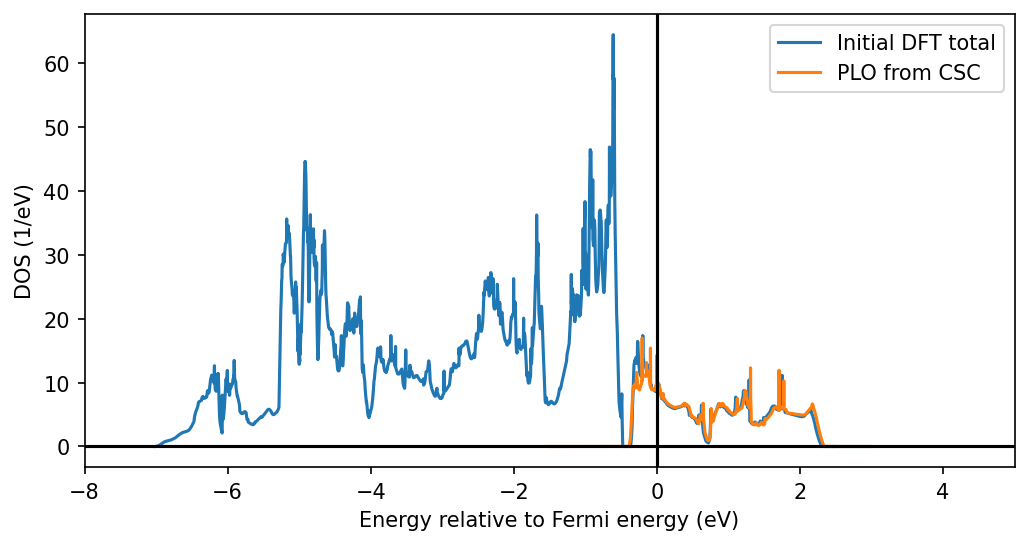

In [88]:
fig, ax = plt.subplots()

ax.plot(dft_energy-fermi_energy, dft_dos, label='Initial DFT total')
ax.plot(energies[0], np.sum(doss, axis=(0, 1)), label='PLO from CSC')
#for energy, dos in zip(energies, doss):
#    ax.plot(energy, dos.T)
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlim(-8, 5)
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
ax.legend()
pass

Shows: We are capturing the right bands, small changes from charge self-consistency

## 3. Analyzing the observables_imp$n$.dat

In [66]:
observables_data = []
for i in range(2):
    with open(f'2_dmft_csc/refs/observables_imp{i}.dat', 'r') as file:
        observables_data.append(np.loadtxt((line.replace('|', '') for line in file), skiprows=1))
observables_data = np.array(observables_data)

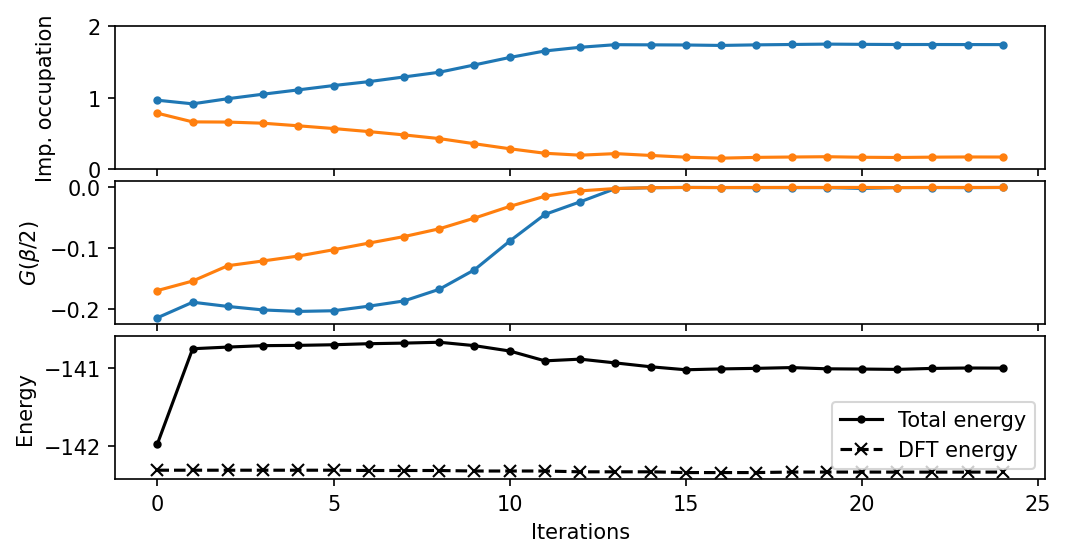

In [85]:
fig, axes = plt.subplots(nrows=3, sharex=True)

for i in range(2):
    axes[0].plot(observables_data[i, :, 6], '.-', c=f'C{i}')
    axes[1].plot(observables_data[i, :, 2]+observables_data[i, :, 3], '.-', c=f'C{i}')
    
# Not impurity-dependent
axes[2].plot(observables_data[0, :, 7], '.-', c='k', label='Total energy')
axes[2].plot(observables_data[0, :, 8], 'x--', c='k', label='DFT energy')

axes[0].set_ylabel('Imp. occupation\n')
axes[0].set_ylim(0, 2)
axes[1].set_ylabel(r'$G(\beta/2)$')
axes[2].set_ylabel('Energy')
axes[2].legend()

axes[-1].set_xlabel('Iterations')
fig.subplots_adjust(hspace=.08)
pass

Shows:
- Occupation converges towards disproportionated 1.8+0.2 electrons state
- Both sites become insulating, relation is $A(\omega = 0) \approx -(\beta/\pi) G(\beta/2)$
- The DFT energy barely changes (this is qualitatively different for other systems!), the total energy converges to value

## 4. Analyzing the h5 archive: the Legendre Green's function

In [89]:
legendre_gf = []
with HDFArchive('2_dmft_csc/refs/vasp.h5') as archive:
    for i in range(2):
        legendre_gf.append(archive[f'DMFT_results/last_iter/Gimp_l_{i}'])

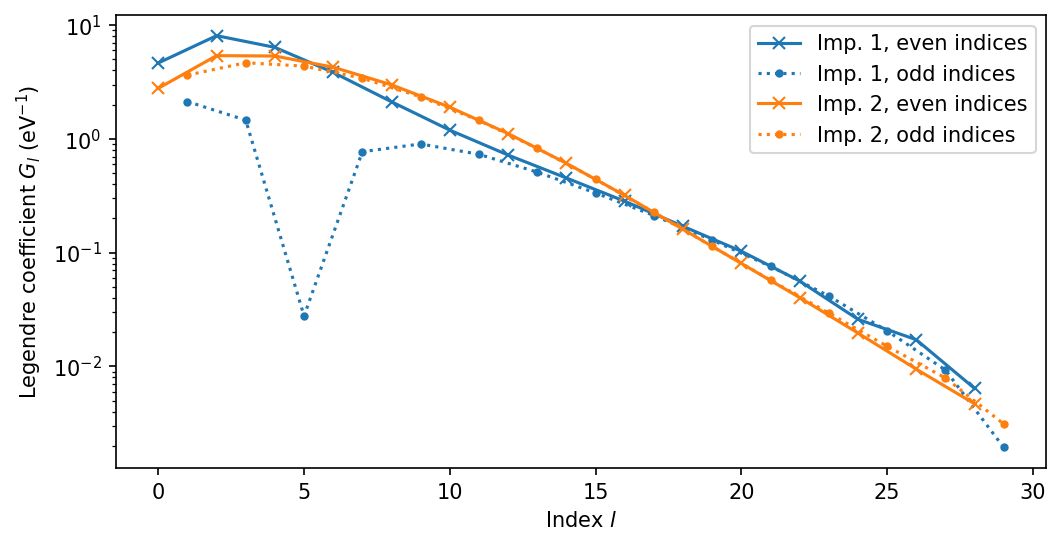

In [90]:
fig, ax = plt.subplots()

for i, legendre_coefficients_per_imp in enumerate(legendre_gf):
    if len(legendre_coefficients_per_imp) != 2:
        raise ValueError('Only blocks up_0 and down_0 supported')

    data = (legendre_coefficients_per_imp['up_0'].data + legendre_coefficients_per_imp['down_0'].data).T

    l_max = data.shape[2]

    ax.semilogy(np.arange(0, l_max, 2), np.abs(np.trace(data[:, :, ::2].real, axis1=0, axis2=1)), 'x-',
                c=f'C{i}', label=f'Imp. {i+1}, even indices')
    ax.semilogy(np.arange(1, l_max, 2), np.abs(np.trace(data[:, :, 1::2].real, axis1=0, axis2=1)), '.:',
                c=f'C{i}', label=f'Imp. {i+1}, odd indices')

ax.legend()

ax.set_ylabel('Legendre coefficient $G_l$ (eV$^{-1}$)')
ax.set_xlabel(r'Index $l$')
pass

Discuss:
- Choice of n_l: If too small, we are missing information. If too large, not filtering noise efficiently noise
- Often effective noise filter. See also doi.org/10.1103/PhysRevB.84.075145
- Noise should reduce with sqrt(n_cycles_tot) for QMC calculations but prefactor depends on material and its Hamiltonian, the electron filling, ...

## 5. Further things to try here
- change U and J and try to see if you can reach a metallic state. What does the occupation look like?

# To do
- add flag to plot files in refs folder or not